### 자연어 처리
- BOW: 문서의 특징 파악 용이 (단어의 순서가 무시됨, eda로만 사용)
- Word2Vec: 밀집벡터 표햔, 의미적 유사성 반영(문맥정보 반영, 단어임베딩때 사용)

In [1]:
#코랩 한국어 오류
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

from matplotlib import rc
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
!pip install konlpy

In [3]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [4]:
import re
from tqdm import tqdm
from konlpy.tag import Okt
from collections import Counter
import konlpy

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/emo.csv")

In [7]:
df = df[['Sentence', 'Emotion']]

In [8]:
df

Sentence Emotion
0                              일은 왜 해도 해도 끝이 없을까? 화가 난다.      분노
1         이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.      분노
2      회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...      분노
3      직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...      분노
4                  얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.      분노
...                                                  ...     ...
59473                                           앙이들 화이팅!      기쁨
59474                              ㅋㅋㅋㅋㅋㅋㅋ졸 우낀다 ㅎ 주사 ㅋㅋㅋ      기쁨
59475                   31년차 주부이지만 늘 백샘 요리보고 배우는 게 많아요~~      기쁨
59476                          이병헌이랑 사탕키스 찍던 게 엊그제 같은데..      기쁨
59477                                      제습기 틀면 뽀송해진다.      기쁨

[59478 rows x 2 columns]

In [9]:
# 중복 리뷰 삭제: 43건
df.drop_duplicates(subset = ['Sentence'], inplace = True)
59478 - len(df)

43

In [10]:
#결측치 없음
df.isnull().sum()

Sentence    0
Emotion     0
dtype: int64

In [11]:
df['Emotion'].value_counts()

불안    9316
분노    9157
상처    9135
기쁨    9131
슬픔    9119
당황    8749
중립    4828
Name: Emotion, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

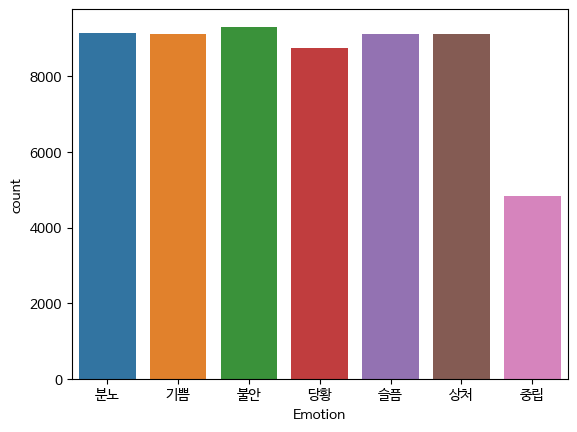

In [12]:
sns.countplot(x='Emotion', data= df)

In [13]:
# 문장길이 컬럼 추가
df['length'] = df['Sentence'].str.len()
df.head()

Sentence Emotion  length
0                          일은 왜 해도 해도 끝이 없을까? 화가 난다.      분노      25
1     이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.      분노      46
2  회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...      분노      54
3  직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...      분노      50
4              얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.      분노      37

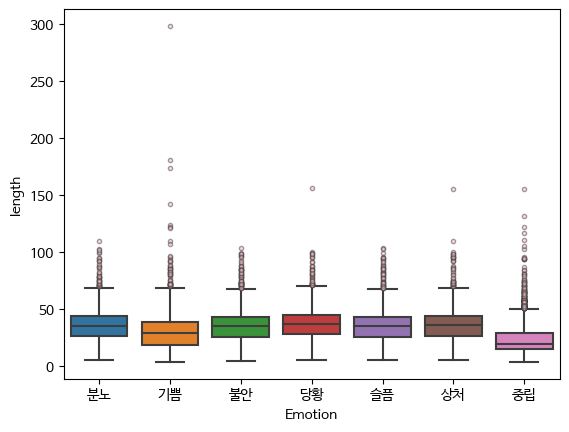

In [14]:
## 감정별 문장길이 (boxplot)
# 특징이 두드러진 기쁨, 중립

outlier = dict(marker='o', markersize=3, markerfacecolor='pink', alpha=0.5)
sns.boxplot(x = "Emotion", y = "length", data = df, flierprops= outlier)
plt.show()

In [15]:
## 특징이 두드러진 기쁨, 중립
df.groupby('Emotion').describe()

length                                                    
          count       mean        std  min   25%   50%   75%    max
Emotion                                                            
기쁨       9131.0  29.907568  13.796225  4.0  19.0  29.0  39.0  298.0
당황       8749.0  36.349183  11.674014  6.0  28.0  37.0  45.0  156.0
분노       9157.0  35.314077  11.787458  6.0  27.0  35.0  44.0  110.0
불안       9316.0  35.019751  11.729645  5.0  26.0  35.0  43.0  104.0
상처       9135.0  35.613684  12.083072  6.0  27.0  36.0  44.0  155.0
슬픔       9119.0  34.995285  11.873154  6.0  26.0  35.0  43.0  104.0
중립       4828.0  23.648302  12.866132  4.0  15.0  20.0  29.0  155.0

## 라벨 인코딩
0. 기쁨
1. 당황
2. 분노
3. 불안
4. 상처
5. 슬픔
6. 중립



In [16]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df['Emotion'])

LabelEncoder()

In [17]:
df["Label_Encoder"] = encoder.transform(df['Emotion'])
df

Sentence Emotion  length  \
0                              일은 왜 해도 해도 끝이 없을까? 화가 난다.      분노      25   
1         이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.      분노      46   
2      회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...      분노      54   
3      직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...      분노      50   
4                  얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.      분노      37   
...                                                  ...     ...     ...   
59473                                           앙이들 화이팅!      기쁨       8   
59474                              ㅋㅋㅋㅋㅋㅋㅋ졸 우낀다 ㅎ 주사 ㅋㅋㅋ      기쁨      21   
59475                   31년차 주부이지만 늘 백샘 요리보고 배우는 게 많아요~~      기쁨      32   
59476                          이병헌이랑 사탕키스 찍던 게 엊그제 같은데..      기쁨      25   
59477                                      제습기 틀면 뽀송해진다.      기쁨      13   

       Label_Encoder  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  
...              ...  
59473              0  
59474              0  
59475              0  
59476              0  
59477              0  

[59435 rows x 4 columns]

In [18]:
df_new = df[['Sentence', 'Label_Encoder', 'Emotion']]

In [19]:
df_new

Sentence  Label_Encoder  \
0                              일은 왜 해도 해도 끝이 없을까? 화가 난다.              2   
1         이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.              2   
2      회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...              2   
3      직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...              2   
4                  얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.              2   
...                                                  ...            ...   
59473                                           앙이들 화이팅!              0   
59474                              ㅋㅋㅋㅋㅋㅋㅋ졸 우낀다 ㅎ 주사 ㅋㅋㅋ              0   
59475                   31년차 주부이지만 늘 백샘 요리보고 배우는 게 많아요~~              0   
59476                          이병헌이랑 사탕키스 찍던 게 엊그제 같은데..              0   
59477                                      제습기 틀면 뽀송해진다.              0   

      Emotion  
0          분노  
1          분노  
2          분노  
3          분노  
4          분노  
...       ...  
59473      기쁨  
59474      기쁨  
59475      기쁨  
59476      기쁨  
59477      기쁨  

[59435 rows x 3 columns]

### 시각화
1. 문자열 전처리(정규표현식)
2. 의미있는 키워드 빈도분석
3. 관련있는 키워드 시각화 (워드클라우드)

In [20]:
# 한글이 아닌 문자는 공백으로 처리
def extract_word(text):
    kor = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    res = kor.sub(' ', text)
    return res

df_new['Sentence'] = df_new['Sentence'].apply(lambda x: extract_word(x) if isinstance(x, str) else '')
df_new.head()

Sentence  Label_Encoder Emotion
0                          일은 왜 해도 해도 끝이 없을까  화가 난다               2      분노
1     이번 달에 또 급여가 깎였어  물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나               2      분노
2  회사에 신입이 들어왔는데 말투가 거슬려  그런 애를 매일 봐야 한다고 생각하니까 스...              2      분노
3  직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜  일도 많은 데 정말 분하고 ...              2      분노
4              얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나               2      분노

In [21]:
df_new['length'] = df_new['Sentence'].str.len()
df_new.head()

Sentence  Label_Encoder Emotion  \
0                          일은 왜 해도 해도 끝이 없을까  화가 난다               2      분노   
1     이번 달에 또 급여가 깎였어  물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나               2      분노   
2  회사에 신입이 들어왔는데 말투가 거슬려  그런 애를 매일 봐야 한다고 생각하니까 스...              2      분노   
3  직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜  일도 많은 데 정말 분하고 ...              2      분노   
4              얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나               2      분노   

   length  
0      25  
1      46  
2      54  
3      50  
4      37

In [22]:
df_new.groupby('Label_Encoder').size().reset_index(name = 'count')

Label_Encoder  count
0              0   9131
1              1   8749
2              2   9157
3              3   9316
4              4   9135
5              5   9119
6              6   4828

### 의미있는 키워드 추출, 빈도수 확인
- Twitter 토크나이저로 하니까 단어 빈도수가 거의 다 1임

In [23]:
from konlpy.tag import Twitter #토큰화1
#from konlpy.tag import okt #토큰화2

In [24]:
twt = Twitter()

In [65]:
# 불용어 사전
!wget https://raw.githubusercontent.com/byungjooyoo/Dataset/main/ko_stopwords.txt
with open("ko_stopwords.txt", 'r') as f:
    stopwords = ['정말', '오늘', '이번', '우리', '이제', '지금', '진짜', '항상', '때문', '요즘', '자꾸'] #1차 추가
    for line in f.readlines():
        stopwords.append(line.strip())
print('한글 불용어 개수:', len(stopwords))
print(stopwords)

--2023-08-08 12:16:11--  https://raw.githubusercontent.com/byungjooyoo/Dataset/main/ko_stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6944 (6.8K) [text/plain]
Saving to: ‘ko_stopwords.txt.2’

ko_stopwords.txt.2  100%[===================>]   6.78K  --.-KB/s    in 0s      

2023-08-08 12:16:11 (65.8 MB/s) - ‘ko_stopwords.txt.2’ saved [6944/6944]

한글 불용어 개수: 679
['정말', '오늘', '이번', '우리', '이제', '지금', '진짜', '항상', '때문', '요즘', '자꾸', '아', '휴', '어', '나', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비

In [66]:
all_words = []
parts =['Noun']
for i in range(len(df_new)):
    text = df_new['Sentence'].iloc[i]
    words = twt.pos(text)
    words_arr = []
    for n in words:
        if n =='EOS' or n =="":continue
        word_tmp=n[0]
        part = n[1]
        if not (part in parts):continue
        if len(word_tmp) >= 2 and word_tmp not in stopwords: #문자길이가 2 이상인 조건 추가
            words_arr.append(word_tmp)
    all_words.extend(words_arr)
print(all_words)

['해도', '해도', '화가', '급여', '물가', '월급', '화가', '회사', '신입', '말투', '매일', '생각', '스트레스', '직장', '막내', '이유', '온갖', '심부름', '일도', '입사', '신입사원', '무시', '화가', '직장', '진로', '대한', '고민', '성인', '진로', '부모님', '퇴사', '직장', '졸업', '취업', '생각', '직장', '생활', '취업', '나이', '취업', '면접', '부모님', '직업', '대한', '질문', '큰일', '부장', '결재', '서류', '제출', '면접', '회사', '면접', '합격', '연락', '다시', '입사', '취소', '통보', '가다가', '동네', '아주머니', '취업', '당황', '어제', '합격', '통보', '회사', '문자', '잘못', '발송', '연락', '출근', '당황', '직장', '이직', '글쎄', '사람', '아주', '당황', '코로나', '수가', '취직', '준비', '시험', '줄줄이', '취소', '마비', '회사', '실수', '취업', '관련', '해도', '온몸', '마비', '어제', '야근', '야근', '회사', '사내', '분위기', '회사', '직장', '생각', '회사', '시험', '시험', '결과', '면접', '면접', '연봉', '실수', '령액', '차이', '지인', '취업', '사기', '배신', '부모님', '거나', '진로', '대해', '걱정', '걱정', '주지', '계속', '취업', '버려진', '기분', '중소기업', '취업', '친구', '저번', '친구', '회사', '면접', '창피해', '청년', '실업률', '취업', '기업', '채용', '직장', '화가', '엄마', '진로', '문제', '크게', '화가', '면접', '부모님', '취업', '잔소리', '잔소리', '화가', '주변', '친구', '취업', '걱정', '코로나', '출근', '내년', '졸업'

### 빈도분석

In [28]:
from collections import Counter

In [68]:
# 형태소 리스트를 카운팅하여 빈도 계산
word_counts = Counter(all_words)

# 빈도가 높은 형태소 순서로 출력
for word, count in word_counts.most_common():
    print(f'{word}: {count}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
치명: 1
홍조: 1
만삭: 1
기저: 1
분풀이: 1
담합: 1
사후세계: 1
사진관: 1
햇살: 1
환호성: 1
공용: 1
문단속: 1
혈기: 1
왕성: 1
페이스: 1
위장병: 1
헤드셋: 1
생사: 1
불분명: 1
위임: 1
가스요금: 1
핼쑥: 1
복판: 1
도라지: 1
녹용: 1
부침개: 1
재항암: 1
방인: 1
가트: 1
패물: 1
금지법: 1
납입: 1
라이딩: 1
뽀삐: 1
견주: 1
쌍방: 1
안경점: 1
콩나물: 1
영상통화: 1
학연: 1
혈연: 1
경제사: 1
낙상: 1
퀴즈쇼: 1
호언: 1
게걸: 1
허겁지겁: 1
살로: 1
전염: 1
선천성: 1
구강: 1
유지비: 1
광부: 1
열세: 1
법석: 1
부숴: 1
여행기: 1
래서야: 1
편백: 1
빠듯할: 1
손익: 1
려면: 1
말론: 1
헛딛는: 1
염소: 1
회서: 1
이십만: 1
타라: 1
층집: 1
하룻밤: 1
안락사: 1
골증: 1
치주염: 1
기침약: 1
발육: 1
깨나: 1
대표이사: 1
출산휴가: 1
의례: 1
수속: 1
꼬셔: 1
서포터: 1
대게: 1
가계약: 1
역서: 1
크루즈: 1
뀌었는데: 1
금치: 1
가스레인지: 1
차차: 1
드림: 1
놨는: 1
독극물: 1
군것질: 1
비축: 1
식물인간: 1
호명: 1
안지: 1
매기: 1
구도: 1
이상신: 1
과묵: 1
한량: 1
사철: 1
위반: 1
육십오: 1
장마철: 1
장대: 1
식충이: 1
불장난: 1
파마: 1
레고: 1
모기지론: 1
친한척: 1
과신: 1
탕수육: 1
유골: 1
소실: 1
눈살: 1
할멈들: 1
요구르트: 1
좌지우지: 1
줏대: 1
이탈: 1
거역: 1
하진: 1
숟가락: 1
이중성: 1
대여: 1
가군: 1
솔루션: 1
우정은: 1
위계: 1
빈둥대: 1
망중: 1
다재: 1
독차지: 1
바이크: 1
폐쇄되어: 1
전세계약: 1
목장: 1
물배: 1
비키: 1
제빵: 1
본체: 1
한살이: 1
유형: 1
설문지:

In [69]:
# 빈도가 높은 상위 30개의 형태소만 추출하여 막대그래프
top_words = word_counts.most_common(30)
x = [word for word, count in top_words]
y = [count for word, count in top_words]

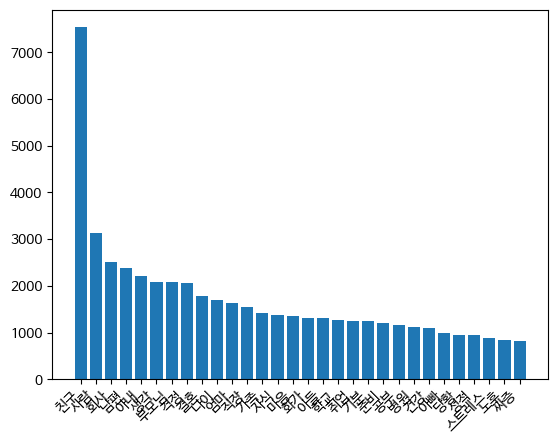

In [70]:
plt.bar(x, y)
plt.xticks(rotation=45, ha='right')
plt.show()

### 워드클라우드
- 전체
- 감정별

In [32]:
pip install wordcloud

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

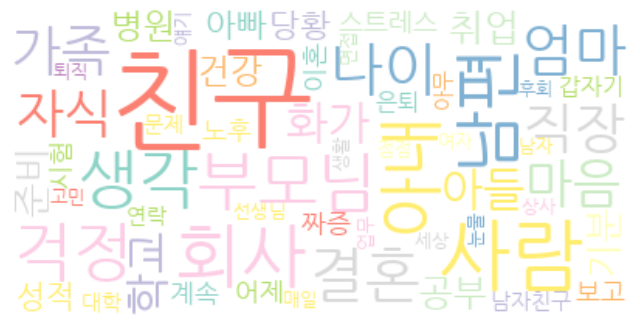

In [72]:
# 감정(전체) 워드클라우드
# 워드클라우드 결과: 매우 일상적인 단어들이 빈도수 상위 차지
wordcloud = WordCloud(
    font_path='NanumGothic', #코랩에서 나눔고딕해야 한국어 안깨짐
    background_color='white',
    min_font_size=12,
    max_font_size=70,
    colormap= 'Set3', #팔레트 지정
).generate_from_frequencies(word_counts)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 일부 감정 한정 워드클라우드
- 0: 기쁨
- 5: 슬픔

In [39]:
happy = df[df['Label_Encoder'] == 0]
happy.head()

Sentence Emotion  length  Label_Encoder
7       퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.      기쁨      29              0
9            요즘 직장생활이 너무 편하고 좋은 것 같아!      기쁨      24              0
10           취업해야 할 나이인데 취업하고 싶지가 않아.      기쁨      24              0
22              우리 회사는 정말 사내 분위기가 좋아.      기쁨      21              0
23  오늘 내가 다니는 회사가 참 좋은 직장이라는 생각이 들었어.      기쁨      33              0

In [73]:
happy_words = []
parts =['Noun'] #명사 추출

for i in range(len(happy)):
    text = happy['Sentence'].iloc[i]
    words = twt.pos(text)
    words_arr_1 = []
    for n in words:
        if n =='EOS' or n =="":continue
        word_tmp=n[0]
        part = n[1]
        if not (part in parts):continue
        if len(word_tmp) >= 2 and word_tmp not in stopwords: #불용어 추가
            words_arr_1.append(word_tmp)
    happy_words.extend(words_arr_1)
print(happy_words)

['퇴사', '직장', '직장', '생활', '취업', '나이', '취업', '회사', '사내', '분위기', '회사', '직장', '생각', '회사', '시험', '시험', '결과', '입사', '면접', '회사', '신뢰', '기분', '먼저', '취업', '선배', '면접', '비결', '면접', '직장', '상사', '칭찬', '취업', '사장', '칭찬', '매우', '지난주', '회사', '원서', '접수', '합격', '매우', '회사', '취업', '네이버', '인턴', '면접', '결혼', '그녀', '자고', '고백', '기분', '최근', '면접', '회사', '다행', '부분', '연애', '시작', '지원', '회사', '최종', '합격', '기분', '유튜브', '십만', '독자', '도달', '신입', '회사', '정식', '사원', '승진', '신입', '회사', '정식', '사원', '승진', '대인관계', '이성', '대해', '자신감', '취업', '입사', '지원', '사람', '대인관계', '취업', '정신', '마음', '여자친구', '바람', '의심', '여자친구', '프러포즈', '확신', '사람', '고백', '느낌', '사람과', '전화번호', '교환', '대표', '갑자기', '대학원', '제안', '단계', '발전', '기회', '대학', '수학', '능력', '시험', '서울대', '지원', '독립', '결혼', '사람', '동업', '친구', '부탁', '마무리', '중이', '부하', '직원', '일도', '신뢰', '준비', '자격증', '시험', '합격', '눈물', '친구', '어젯밤', '연락', '신뢰', '친구', '아내', '출산', '기분', '어제', '실수', '삭제', '프레', '테이', '자료', '복구', '회의', '어제', '아내', '출산', '마음', '여자친구', '임신', '임신', '기분', '소식', '준비', '공무원', '시험', '합격', '발표', '기간', 

In [76]:
# 형태소리스트 카운팅 -> 빈도 계산
happy_counts = Counter(happy_words)

# 빈도가 높은 형태소 순서로 출력
for word, count in happy_counts.most_common():
    print(f'{word}: {count}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
확신: 17
기업: 17
신경: 17
만성: 17
손녀: 17
제대로: 17
진행: 17
체력: 17
부장: 17
괴롭힘: 17
전화: 17
대로: 17
보람: 17
일찍: 17
학원: 17
직업: 17
사과: 17
누나: 17
천식: 17
날씨: 17
댓글: 17
엘지: 17
지난주: 16
정신: 16
예정: 16
나니: 16
자랑: 16
별로: 16
가입: 16
사고: 16
실적: 16
프로그램: 16
수가: 16
시기: 16
이면: 16
편이: 16
필요: 16
운영: 16
편지: 16
나라: 16
근무: 15
화목: 15
이십: 15
거래처: 15
동창: 15
주어: 15
만난: 15
작년: 15
만기: 15
위로: 15
발견: 15
등산: 15
고혈압: 15
배려: 15
한결: 15
정상: 15
다리: 15
외식: 15
수치: 15
과장: 15
카페: 15
수능: 15
기말고사: 15
식구: 15
선택: 15
수업: 15
효과: 15
무도: 15
자신감: 14
일도: 14
자격증: 14
세계: 14
전혀: 14
평가: 14
파티: 14
월급: 14
영어: 14
통해: 14
검사: 14
여러: 14
만날: 14
교통사고: 14
프로: 14
웃음: 14
성적표: 14
가슴: 14
무한도전: 14
아마: 13
역사: 13
집안일: 13
가격: 13
취미: 13
모의고사: 13
화가: 13
일주일: 13
현재: 13
성과: 13
길이: 13
정리: 13
긴장: 13
주신: 13
유학: 13
시골: 13
남지: 13
무조건: 13
큰일: 13
작가: 13
머리: 13
관절염: 13
승리: 13
보검: 13
삼성: 13
레시피: 13
대인관계: 12
대표: 12
제안: 12
능력: 12
최선: 12
이해: 12
노년: 12
절대: 12
이자: 12
야근: 12
분명: 12
인상: 12
혈압: 12
정년: 12
미국: 12
감격: 12
대신: 12
교수: 12
용기: 12
여름: 12
정보: 12
가

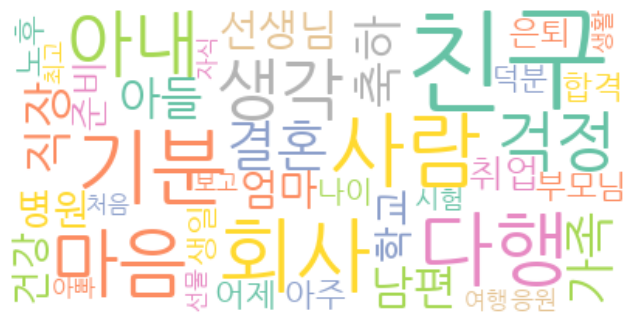

In [77]:
wordcloud = WordCloud(
    font_path='NanumGothic',
    background_color='white',
    min_font_size=15,
    max_font_size=70,
    colormap= 'Set2',
).generate_from_frequencies(happy_counts)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [78]:
top_happy_words = happy_counts.most_common(30)
x1 = [word for word, count in top_happy_words]
y1 = [count for word, count in top_happy_words]

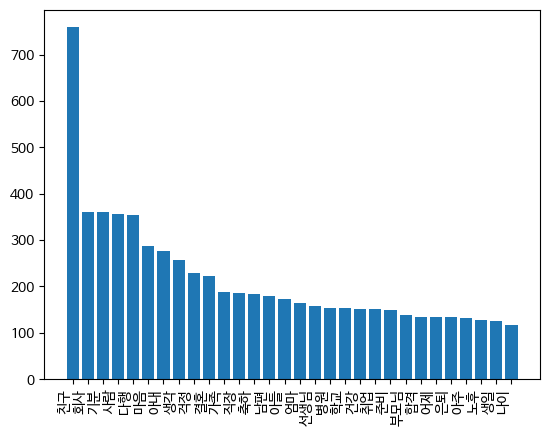

In [79]:
plt.bar(x1, y1)
plt.xticks(rotation=90, ha='right')
plt.show()

In [80]:
# 슬픔
sad = df[df['Emotion'] == '슬픔']
sad.head()

Sentence Emotion  length  \
18  코로나 때문에 뭘 할 수가 없어. 취직 준비를 해야 하는데 시험이 줄줄이 취소되니 ...      슬픔      76   
19                              오늘 회사에서 큰 실수를 한 것 같아.      슬픔      21   
20                  요즘 취업 관련해서 떠올리기만 해도 온몸이 마비될 것 같아.      슬픔      33   
21                           어제도 야근 오늘도 야근이야. 너무 힘들어.      슬픔      24   
40  직장 생활 육 개월 차인데 아직도 적응하기가 힘들어. 사회생활이 이렇게 괴롭고 슬픈...      슬픔      59   

    Label_Encoder  
18              5  
19              5  
20              5  
21              5  
40              5

In [81]:
sad_words = []
parts =['Noun'] #명사 추출

for i in range(len(sad)):
    text = sad['Sentence'].iloc[i]
    words = twt.pos(text)
    words_arr_2 = []
    for n in words:
        if n =='EOS' or n =="":continue
        word_tmp=n[0]
        part = n[1]
        if not (part in parts):continue
        if len(word_tmp) >= 2 and word_tmp not in stopwords:
            words_arr_2.append(word_tmp)
    sad_words.extend(words_arr_2)
print(sad_words)

['코로나', '수가', '취직', '준비', '시험', '줄줄이', '취소', '마비', '회사', '실수', '취업', '관련', '해도', '온몸', '마비', '어제', '야근', '야근', '직장', '생활', '개월', '사회생활', '면접', '마음', '취업', '구직', '자리', '취업', '시장', '직장', '회사', '해고', '직장', '퇴사', '진로', '문제', '고민', '고객', '폭언', '자존감', '올해', '진급', '예정', '진급', '취업', '면접', '코로나바이러스', '회사', '해고', '면접', '실망', '마음', '면접', '실패', '취직', '취업', '회사', '처음', '갈수록', '별로', '대학', '졸업', '공무원', '시험', '준비', '이력서', '여러', '연락', '복도', '마음', '취업', '준비', '갑자기', '졸업', '취업', '보육', '교사', '직업', '점점', '점점', '결혼', '아내', '매일', '잔소리', '아내', '엄마', '물건', '사도', '난리', '계약', '정규직', '퇴사', '사람', '배신', '당하', '면접', '벌써', '면접', '실망', '회사', '면접', '대답', '선생님', '출발', '학원', '정이', '나중', '진로', '세태', '회의', '사나', '직업', '선택', '프로젝트', '채택', '팀원', '대학원', '가지', '공부', '볼걸', '공부', '후회', '취업', '생각', '동생', '취업', '마음', '수가', '취업', '회사', '지원', '결과', '눈물', '사내', '정치', '환멸', '월급쟁이', '끼리', '일인', '사람', '기계', '반응', '아내', '임신', '중이', '나름', '사람', '배신', '당하', '약속', '친구', '실망', '직업', '후회', '여자', '결혼', '생각', '결혼', '생각', '중이', '여자친구', '부모님', '결

In [82]:
sad_counts = Counter(sad_words)

for word, count in sad_counts.most_common():
    print(f'{word}: {count}')

친구: 1216
생각: 454
사람: 443
부모님: 433
아내: 415
회사: 406
눈물: 403
남편: 386
나이: 351
엄마: 349
결혼: 324
마음: 298
후회: 293
가족: 269
자식: 262
직장: 238
학교: 219
병원: 215
취업: 212
아빠: 210
성적: 207
아들: 197
공부: 195
이혼: 195
준비: 193
걱정: 192
건강: 171
실망: 158
세상: 150
어제: 144
대학: 139
기분: 139
시험: 138
계속: 133
아무: 133
노후: 126
보고: 124
생활: 113
우울증: 113
스트레스: 104
환멸: 102
점점: 99
은퇴: 99
문제: 93
매일: 93
따돌림: 93
남자친구: 91
마비: 89
퇴직: 86
상사: 85
상황: 85
갑자기: 84
수가: 82
면접: 82
업무: 80
여자친구: 78
얘기: 78
코로나: 75
연락: 74
인생: 74
치매: 74
고민: 73
예전: 73
무시: 72
벌써: 71
여자: 71
모습: 71
진로: 70
주변: 68
사고: 67
장애: 67
선생님: 66
위해: 66
남자: 66
대해: 66
관계: 65
다리: 65
화가: 64
노인: 63
이유: 63
연애: 62
사실: 62
요새: 61
교통사고: 60
최근: 59
사랑: 58
치료: 58
감정: 58
경제: 57
소득: 57
자주: 56
동료: 56
노력: 56
해도: 54
결과: 54
그동안: 54
이야기: 54
별로: 53
가지: 53
동생: 53
지원: 53
크게: 52
관심: 52
달라: 52
어머니: 51
시작: 51
취직: 50
입원: 50
제대로: 50
승진: 49
대화: 49
대학교: 49
아버지: 49
직업: 48
진단: 48
현실: 48
고생: 48
정신: 47
나니: 47
점수: 46
신경: 46
상태: 45
출산: 45
평생: 45
소식: 45
당뇨: 45
머리: 44
먼저: 44
사이: 44
졸업: 43
느낌: 42
할머니: 42
생일: 42
자녀: 42

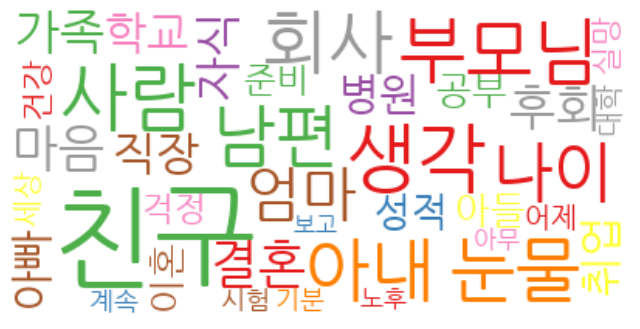

In [83]:
wordcloud = WordCloud(
    font_path='NanumGothic',
    background_color='white',
    min_font_size=15,
    max_font_size=70,
    colormap= 'Set1',
).generate_from_frequencies(sad_counts)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [84]:
top_sad_words = sad_counts.most_common(30)
x2 = [word for word, count in top_sad_words]
y2 = [count for word, count in top_sad_words]

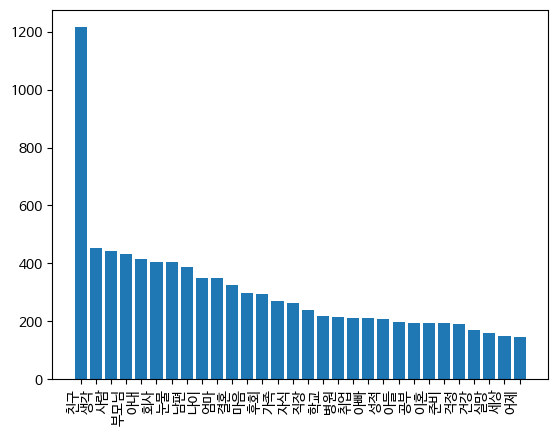

In [85]:
plt.bar(x2, y2)
plt.xticks(rotation=90, ha='right')
plt.show()

In [86]:
# 중립
med = df[df['Emotion'] == '중립']
med.head()

Sentence Emotion  length  Label_Encoder
51630           소량은 먹어도 인체에 해롭지 않고요.      중립      21              6
51631  그래도 청문회 나온 놈들보다는 정직한 대답 한것 같다      중립      29              6
51632           이런일 터지기전에 이미 계약 했을까?      중립      21              6
51633                좀더 신중할필요가 있다...      중립      16              6
51634                   이번엔 베터리 색상은?      중립      12              6

In [87]:
med_words = []
parts =['Noun'] #명사 추출

for i in range(len(med)):
    text = med['Sentence'].iloc[i]
    words = twt.pos(text)
    words_arr_3 = []
    for n in words:
        if n =='EOS' or n =="":continue
        word_tmp=n[0]
        part = n[1]
        if not (part in parts):continue
        if len(word_tmp) >= 2 and word_tmp not in stopwords:
            words_arr_3.append(word_tmp)
    med_words.extend(words_arr_3)
print(med_words)

['소량', '인체', '청문회', '대답', '기전', '계약', '좀더', '필요', '베터리', '색상', '탈모', '아버지', '머리', '가풍', '아들', '탈모', '아버지', '탈모', '아들', '머리', '사람', '최형우', '계약금', '최소', '연봉', '최대로', '제작', '하자', '위안부', '문제', '민간', '일이', '극우파', '초강대국', '소련', '예외', '테임', '공격', '주루', '부각', '경향', '수비', '보우', '올해', '마지막', '경기', '가을', '오호츠크해', '기단', '영향', '사회', '법치', '교육', '봉사', '희생', '헌신', '기사', '제목', '사심', '기사', '거나', '축구', '비유', '하자', '호날두', '메시', '발롱도르', '출발', '시민', '피해', '생각', '기아', '수비', '혈액', '검사', '금방', '댓글', '휴게소', '감독', '경질', '후반', '브래드', '매덕스', '자식', '대한', '사랑', '자원봉사', '의류', '매장', '집중', '지방', '참여', '사람', '미국', '여친', '후보', '마이걸', '후보', '누가', '인생', '마감', '수장', '태호', '여러가지', '의견', '반영', '결정', '상민', '이형', '룰라', '올해', '마사지', '업소', '냉동', '기증', '준비운동', '보수', '젊은이', '별로', '과장', '두산', '한국', '이면', '계란', '그게', '판결', '영향', '류현진', '어물', '거리', '선거', '아웃', '우리나라', '서울', '수도권', '인구', '밀도', '테러', '상자', '파스타', '세계대전', '개발', '법학', '현재', '로스쿨', '재학', '금액', '축소', '발표', '인정', '일본', '대사관', '영사관', '설치', '정부', '독려', '임창용', '걱정', '안해', '김종민

In [88]:
med_counts = Counter(med_words)

for word, count in med_counts.most_common():
    print(f'{word}: {count}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
손석희: 3
종이: 3
도서: 3
강동원: 3
오징어: 3
춥다: 3
공감: 3
배달: 3
하야: 3
연예계: 3
음식: 3
그닥: 3
정확: 3
로우: 3
가치: 3
기레기: 3
한글: 3
참석: 3
전기차: 3
어버이연합: 3
이민: 3
불어: 3
실수: 3
캠프: 3
명의: 3
케이티: 3
세명: 3
글쎄: 3
법적: 3
안함: 3
로만: 3
매우: 3
대면: 3
노인: 3
산업: 3
비행기: 3
소속사: 3
기름: 3
뭐임: 3
합격: 3
커플: 3
여름: 3
최태민: 3
내부: 3
가도: 3
위협: 3
체력: 3
십년: 3
스펙: 3
클래스: 3
지역: 3
유투브: 3
소녀: 3
호텔: 3
워낙: 3
조상: 3
쿵쾅: 3
집안: 3
부리: 3
트럭: 3
혁명: 3
살길: 3
님들: 3
남미: 3
현장: 3
대답: 2
베터리: 2
민간: 2
보우: 2
사심: 2
경질: 2
태호: 2
여러가지: 2
의견: 2
반영: 2
마사지: 2
냉동: 2
기증: 2
상자: 2
세계대전: 2
축소: 2
그대: 2
실시: 2
유엔: 2
총장: 2
클롭: 2
시급: 2
단백질: 2
김구라: 2
양세형: 2
노벨문학상: 2
보관: 2
지급: 2
고참: 2
후임: 2
영양: 2
체중: 2
플라스틱: 2
타이밍: 2
일자리: 2
종일: 2
이태곤: 2
자판: 2
송구: 2
자백: 2
일관: 2
화장실: 2
기절: 2
불균형: 2
혐오: 2
기린: 2
한쪽: 2
백종원: 2
한강: 2
은행: 2
대출: 2
나은: 2
공원: 2
사관: 2
선회: 2
저건: 2
컨텐츠: 2
공짜: 2
정현: 2
출퇴근: 2
노홍철: 2
높이: 2
분류: 2
감기: 2
논란: 2
홍콩: 2
변환: 2
방식: 2
버터: 2
현질: 2
호흡: 2
체인: 2
참고: 2
나경원: 2
본가: 2
인치: 2
안드로이드폰: 2
명예: 2
면제: 2
강하늘: 2
고등학교: 2
자발: 2
체질: 2
메이져: 2
오늘날: 2
수영: 2
파도: 2
샤오미:

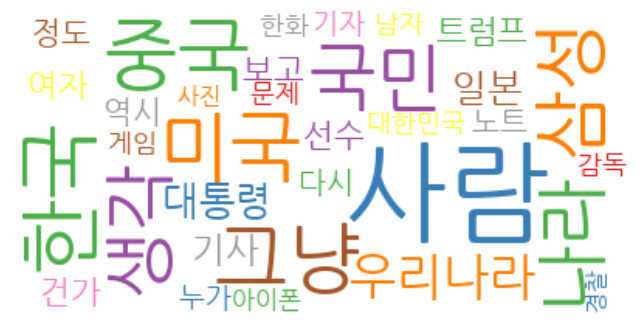

In [89]:
wordcloud = WordCloud(
    font_path='NanumGothic',
    background_color='white',
    min_font_size=15,
    max_font_size=70,
    colormap= 'Set1',
).generate_from_frequencies(med_counts)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [90]:
top_med_words = med_counts.most_common(30)
x3 = [word for word, count in top_med_words]
y3 = [count for word, count in top_med_words]

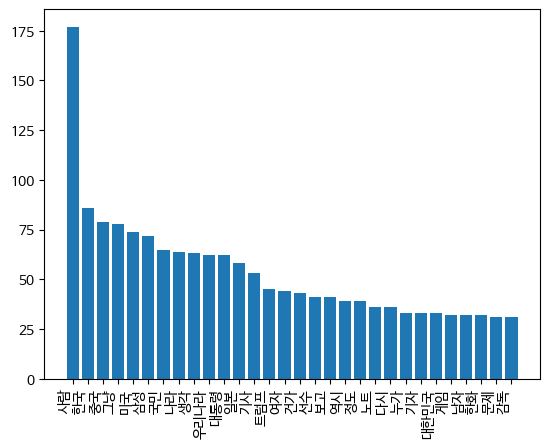

In [91]:
plt.bar(x3, y3)
plt.xticks(rotation=90, ha='right')
plt.show()
# '중립' 관련해서 정치적인 키워드 많음

In [99]:
### 당황
emb = df[df['Emotion'] == '당황']
emb.head()

Sentence Emotion  length  \
14         길을 가다가 우연히 마주친 동네 아주머니께서 취업했냐고 물어보셔서 당황했어.      당황      42   
15  어제 합격 통보를 받은 회사에서 문자를 잘못 발송했다고 연락이 왔어. 너무 당혹스럽...      당황      52   
16                           나 오늘 첫 출근 했는데 너무 당황스러웠어!      당황      24   
17     이번에 직장을 이직했는데 글쎄 만나고 싶지 않은 사람을 만나서 아주 당황스럽더라고.      당황      46   
29            이번에 중소기업에 취업하게 되었어. 친구들에게 말하기가 조금 부끄러워.      당황      39   

    Label_Encoder  
14              1  
15              1  
16              1  
17              1  
29              1

In [101]:
emb_words = []
parts =['Noun'] #명사 추출

for i in range(len(emb)):
    text = emb['Sentence'].iloc[i]
    words = twt.pos(text)
    words_arr_4 = []
    for n in words:
        if n =='EOS' or n =="":continue
        word_tmp=n[0]
        part = n[1]
        if not (part in parts):continue
        if len(word_tmp) >= 2 and word_tmp not in stopwords:
            words_arr_4.append(word_tmp)
    emb_words.extend(words_arr_4)
print(emb_words)

['가다가', '동네', '아주머니', '취업', '당황', '어제', '합격', '통보', '회사', '문자', '잘못', '발송', '연락', '출근', '당황', '직장', '이직', '글쎄', '사람', '아주', '당황', '중소기업', '취업', '친구', '저번', '친구', '회사', '면접', '창피해', '친구', '먼저', '회사', '취직', '학교', '공부', '열등감', '취업', '준비', '요새', '회사', '친구', '보기', '휴대전화', '사람', '사과', '사이', '결혼', '친구', '친구', '갑자기', '결혼', '코앞', '확신', '결혼', '생기', '결혼', '친구', '비교', '결혼', '예식장', '걱정', '공무원', '시험', '준비', '부모님', '교회', '친구', '갑자기', '여자친구', '회사', '보기', '면접', '사람', '발표', '외로워', '연애', '결혼', '결혼', '유부', '남인', '특정', '지역', '혐오', '사이트', '회원', '이야기', '여기저기', '지역', '출신', '소리', '실수', '당황', '회사', '최종', '합격', '당황', '동성', '간의', '연애', '보기', '아빠', '상상', '생각', '부모님', '결혼', '재촉', '기러기', '아빠', '아내', '아들', '보고', '순간', '감정', '친구', '배신', '지은', '느낌', '승승장구', '회사', '동기', '보고', '신경질', '인생', '낙오', '패배', '아내', '아기', '아내', '모습', '아내', '친구', '해외여행', '벌써', '일주일', '아빠', '면접', '탈락', '수가', '실망', '어제', '부인', '방귀', '그것', '소리', '제법', '어제', '여자친구', '기억', '어제', '회사', '동료', '취해', '주사', '여자친구', '갑자기', '이별', '통보', '이유', '여자친구', '결혼', '결혼

In [103]:
emb_counts = Counter(emb_words)

for word, count in emb_counts.most_common():
    print(f'{word}: {count}')

친구: 1594
당황: 750
사람: 624
회사: 433
부모님: 403
죄책감: 403
아내: 397
남편: 371
생각: 338
가족: 298
자식: 283
엄마: 280
결혼: 276
직장: 272
나이: 269
아들: 265
공부: 239
걱정: 233
병원: 218
갑자기: 215
학교: 212
준비: 205
마음: 200
취업: 187
외로워: 183
건강: 182
아빠: 164
후회: 164
잘못: 158
기분: 157
어제: 155
혼란: 151
이혼: 150
성적: 144
보고: 143
노후: 140
아무: 123
남자친구: 122
계속: 120
동생: 119
시험: 110
실수: 109
직원: 108
대학: 107
문제: 103
상사: 101
동료: 100
신경: 100
주변: 99
업무: 95
연락: 94
은퇴: 94
눈치: 91
남자: 91
여자친구: 89
고민: 89
퇴직: 88
매일: 87
열등감: 86
혐오: 84
여자: 82
얘기: 82
느낌: 81
우울증: 79
화가: 77
언니: 74
동기: 72
경제: 72
연애: 71
모습: 71
스트레스: 70
이야기: 69
수가: 69
점점: 69
시선: 68
생활: 68
대해: 66
진로: 66
고생: 65
세상: 64
사실: 64
선생님: 63
사이: 61
수술: 61
입원: 61
제대로: 61
면접: 60
무시: 60
달라: 60
게임: 59
질환: 59
요새: 58
장애: 58
모임: 58
대화: 57
치료: 56
취직: 55
보기: 55
따돌림: 55
가지: 54
벌써: 53
바람: 53
노인: 51
먼저: 50
관리: 50
당뇨: 50
해도: 50
짜증: 50
거짓말: 50
다리: 50
소리: 49
위해: 48
처음: 48
스스로: 48
창피해: 47
상황: 47
자녀: 47
시작: 46
고백: 46
최근: 46
치매: 46
운동: 45
얼굴: 45
그동안: 44
할머니: 44
도움: 44
소득: 44
의사: 43
사고: 42
인정: 42
의식: 42
예전: 42
학원: 42

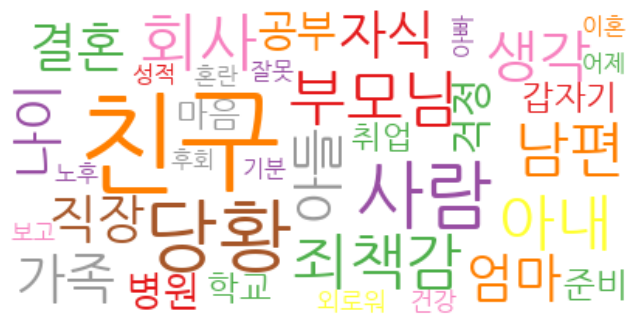

In [104]:
wordcloud = WordCloud(
    font_path='NanumGothic',
    background_color='white',
    min_font_size=15,
    max_font_size=70,
    colormap= 'Set1',
).generate_from_frequencies(emb_counts)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

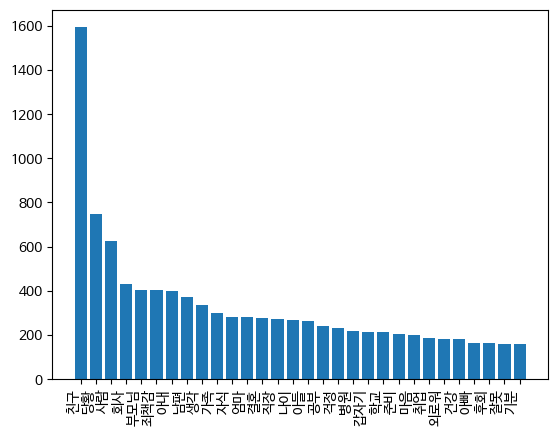

In [106]:
top_emb_words = emb_counts.most_common(30)
x4 = [word for word, count in top_emb_words]
y4 = [count for word, count in top_emb_words]
plt.bar(x4, y4)
plt.xticks(rotation=90, ha='right')
plt.show()